C:\Users\nacho\AppData\Local\Temp\ipykernel_19160\163386850.py:56: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.append(MCMT(ZGate(), n_qubits - 1, 1), range(n_qubits))


Oráculo de Fase para el estado |101>:


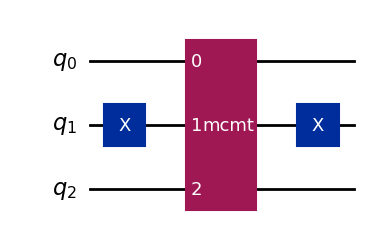

Operador de Difusión (3 qubits):


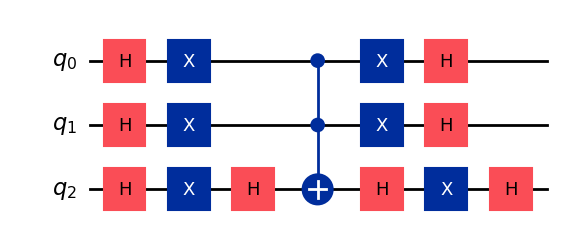

Buscando el estado |1101> en 16 elementos...
Para N=16 (n=4), iteraciones óptimas calculadas: 3


QiskitError: 'One or more instructions cannot be converted to a gate. "mcmt" is not a gate instruction'

In [ ]:
# %% [markdown]
# # Lección 8: Algoritmo de Grover (Versión Corregida)
# Este notebook implementa el algoritmo de búsqueda de Grover utilizando Qiskit.
# Se han corregido las construcciones de las compuertas para asegurar la compatibilidad con el simulador.
#
# ## Contenido:
# 1. Implementación del Oráculo de Fase ($Z_f$) manual (sin MCMT)
# 2. Implementación del Operador de Difusión ($H^{\otimes n} Z_{OR} H^{\otimes n}$)
# 3. Cálculo de iteraciones óptimas
# 4. Ejecución completa del Algoritmo

# %%
# 1. Importaciones
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Simulador
sim = AerSimulator()

# %% [markdown]
# ## 1. El Oráculo de Fase ($Z_f$)
# Implementamos el oráculo usando `MCX` (Multi-Controlled X) rodeada de `H` en el qubit objetivo, lo cual es matemáticamente equivalente a una MCZ.
# Esto evita el error de conversión de `MCMT`.

# %%
def phase_oracle(n_qubits, target_state_str):
    """
    Crea un circuito que implementa el oráculo de fase Z_f para un estado objetivo.
    target_state_str: Cadena binaria del estado a buscar (ej: '101').
    """
    qc = QuantumCircuit(n_qubits)
    
    # Invertimos la cadena para coincidir con el orden de qubits de Qiskit (Little-Endian)
    target_reversed = target_state_str[::-1]
    
    # 1. Aplicar X a los qubits que deben ser 0 para activar el control
    for qubit, char in enumerate(target_reversed):
        if char == '0':
            qc.x(qubit)
            
    # 2. Aplicar MCZ (Multi-Controlled Z)
    # Construcción robusta: H en el objetivo -> MCX -> H en el objetivo
    if n_qubits > 1:
        qc.h(n_qubits - 1)
        qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        qc.h(n_qubits - 1)
    else:
        qc.z(0) # Caso trivial
        
    # 3. Revertir las X (Uncomputation)
    for qubit, char in enumerate(target_reversed):
        if char == '0':
            qc.x(qubit)
            
    return qc

# Visualización
n = 4
target = '1101'
oracle_qc = phase_oracle(n, target)
print(f"Oráculo de Fase corregido para |{target}>:")
display(oracle_qc.draw(output="mpl"))

# %% [markdown]
# ## 2. El Operador de Difusión
# Implementación manual estándar: $H^{\otimes n} \rightarrow X^{\otimes n} \rightarrow MCZ \rightarrow X^{\otimes n} \rightarrow H^{\otimes n}$.

# %%
def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # 1. H a todos
    qc.h(range(n_qubits))
    
    # 2. X a todos
    qc.x(range(n_qubits))
    
    # 3. MCZ (H -> MCX -> H) al estado |11...1>
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    
    # 4. X a todos
    qc.x(range(n_qubits))
    
    # 5. H a todos
    qc.h(range(n_qubits))
    
    return qc

print("Operador de Difusión:")
display(diffuser(4).draw(output="mpl"))

# %% [markdown]
# ## 3. Ensamblaje del Algoritmo de Grover
# Ahora usamos `.to_gate()` sobre nuestros circuitos corregidos, lo cual funcionará correctamente porque solo contienen compuertas estándar.

# %%
def grover_algorithm(n_qubits, target_state_str):
    # 1. Inicialización
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    
    qc.h(qr) # Superposición inicial
    
    # 2. Calcular Iteraciones Óptimas
    N = 2**n_qubits
    iterations = int(np.floor(np.pi/4 * np.sqrt(N)))
    print(f"Para N={N} (n={n_qubits}), buscando '{target_state_str}', iteraciones: {iterations}")
    
    # Convertimos a compuertas para mantener el circuito principal limpio
    # Ahora esto NO fallará
    oracle_gate = phase_oracle(n_qubits, target_state_str).to_gate()
    oracle_gate.name = "Oracle"
    
    diffuser_gate = diffuser(n_qubits).to_gate()
    diffuser_gate.name = "Diffuser"
    
    # 3. Bucle de Grover
    for _ in range(iterations):
        qc.append(oracle_gate, range(n_qubits))
        qc.append(diffuser_gate, range(n_qubits))
        
    # 4. Medición
    qc.measure(qr, cr)
    
    return qc

# Configuración del Experimento
n_sim = 4 
target_sim = '1101' 

print(f"Construyendo circuito Grover...")
qc_grover = grover_algorithm(n_sim, target_sim)
display(qc_grover.draw(output="mpl"))

# %% [markdown]
# ## 4. Ejecución y Simulación

# %%
# Transpilación (necesaria para el simulador)
qc_grover_transpiled = transpile(qc_grover, sim)

# Ejecución
result = sim.run(qc_grover_transpiled, shots=1024).result()
counts = result.get_counts()

print(f"\nResultados brutos: {counts}")
most_frequent = max(counts, key=counts.get)
print(f"Estado encontrado: {most_frequent}")

if most_frequent == target_sim:
    print("¡ÉXITO! El algoritmo encontró el estado correcto.")
else:
    print("FALLO. Revisa las iteraciones o el oráculo.")

plot_histogram(counts)